# Data preparation

As part of the data preparation, the following will be performed:

- Column formatting
- Removal of duplicates.
- Check if missing data and fill.
- Export clean data in long format for EDA in PBI 
- Export clean data in short format for forecasting.


In [10]:
# import dependencies
import pandas as pd
import numpy as np
import statsmodels as sm
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [11]:
# read data
df = pd.read_csv('..\\data\\Historical Product Demand.csv', sep=',')


In [12]:
df.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In [13]:
len(df)

1048575

In [14]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [15]:
cat_columns = ['Product_Code', 'Warehouse', 'Product_Category', 'Date']
cat_columns_no_dt = ['Product_Code', 'Warehouse', 'Product_Category']


In [16]:
df.head()


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [17]:
df.describe(include='all')

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


We need to format the Order_Demand column as number. In addition, we can see there are some dates with null value.

In [18]:

# Let's try to format the Order_demand columns
df.Order_Demand = df.Order_Demand.astype(float)


ValueError: could not convert string to float: '(1)'

We get an error because there are numbers between parenthesis. We will assume that they are positive values which were stored with the wrong format.

In [47]:
# number of records with parenthesis
len(df.loc[df.Order_Demand.str.startswith('(')])


10469

In [48]:
# Let´s replace all those. in other context parenthesis might represent negative values, but it seems unlikely in this case.
df.loc[df.Order_Demand.str.startswith('('), 'Order_Demand'] = df.Order_Demand.str.replace(')', '').str.replace('(', '')
df.Order_Demand = df.Order_Demand.astype(float)

In [49]:
# let´s check the main properties of df again
df.describe(include='all')

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1.048575e+06
unique,2160,4,33,1729,NaN
top,Product_1359,Whse_J,Category_019,2013/9/27,NaN
freq,16936,764447,481099,2075,NaN
mean,NaN,NaN,NaN,NaN,4.906977e+03
std,NaN,NaN,NaN,NaN,2.892678e+04
min,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,2.000000e+01
50%,NaN,NaN,NaN,NaN,3.000000e+02
75%,NaN,NaN,NaN,NaN,2.000000e+03


Now we can see the max and min values of Order_Demand. There is a high dispersion in this columns: there are small groups with large demand and many smaller groups with low demand values.

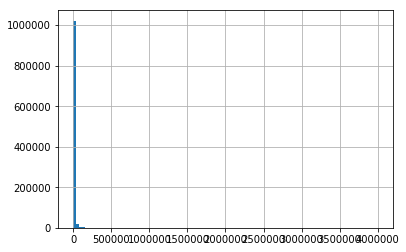

In [50]:
df.Order_Demand.hist(bins=100)

In [51]:
# check if null values
df.isnull().sum()


Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

Let¨s drop those rows.There are not so many (1% of total) and it is not possible to get the right index.



In [52]:
df = df.dropna()

In [53]:
# Removal of duplicates

# check for duplicated rows
df.duplicated().sum() / len(df) 

0.11039817378361495

Hereby it is assumed that duplicated rows are redundant and will be removed. 
Another option would be to assume this data came in different batches, 
i.e. all are valid, and  maybe we should sum them all. 

In [54]:
df = df.drop_duplicates()

In [55]:
# Now let's check for duplicated rows in categorical columns
df.duplicated(subset=['Product_Code', 'Warehouse', 'Product_Category', 'Date']).sum() / len(df) 


0.31237321416186975

Using the same logic applied before, hereby it is assumed that only one in each group of duplicates is valid. But since we don't have any hint we will use the mean of each group.

Next we will split the data between data without duplicates and data with duplicates. After grouping the duplicated ones and calculate the mean, we will put them together again.


In [56]:
# first let's split df into a dataframe without duplicated categorical columns
# and the that
df_no_dupl = df.loc[df.duplicated(subset=cat_columns, keep=False) == False]
df_dupl = df.loc[df.duplicated(subset=cat_columns, keep=False)].sort_values(by=cat_columns)

# let's calculate the mean value in Order_Demand for each group of df_dupl 
df_dupl_avg = df_dupl.groupby(cat_columns)['Order_Demand'].mean().reset_index()

# finally let's append df_dupl_ df without duplicates
df_no_dupl = df_no_dupl.append(df_dupl_avg)


Now let's prepare the short format we will use to forecast. In addition, we will merge with a date range to ensure we dont miss any date in the different time series.


In [57]:

# format date
df_no_dupl.Date = pd.to_datetime(df_no_dupl.Date)

# first we need the dataframe in short format, with date in index and the rest 
# of classes in the columns
df_no_dupl_piv = pd.pivot_table(df_no_dupl, index='Date',
                        columns=['Product_Code', 'Warehouse', 'Product_Category'], 
                        values='Order_Demand', 
                        aggfunc='sum').reset_index()

df_dates = pd.DataFrame(pd.date_range(df_no_dupl.Date.min(), df_no_dupl.Date.max()), columns=['Date'])
len(df_dates)
# 2194 days

#df_dates = pd.DataFrame(pd.date_range(dt.datetime(2012,1,1), dt.datetime(2016,12,31)), columns=['Date'])
df_no_dupl_piv = df_dates.merge(df_no_dupl_piv, how='left', on='Date').set_index('Date')


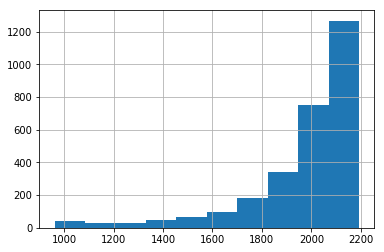

In [58]:
# lets check histogram of null values per time series
fig, ax = plt.subplots()
df_no_dupl_piv.isnull().sum().hist(ax=ax)



In [59]:
df_no_dupl_piv.isnull().sum().min()

962

The minimum number of missing dates in a time series corresponds to almost 3 years of data

In [60]:
df_no_dupl_piv.isnull().sum().max()


2193

There are time series for which only one day in the entire series is not null


In [61]:

# let's check if null values are actually zero, i.e. in order to save space
# data is stored only for non-zero values. We can check this in df_no_dupl.
# How many zeros we have in the data?
len(df_no_dupl.loc[df_no_dupl['Order_Demand'] == 0])


7049

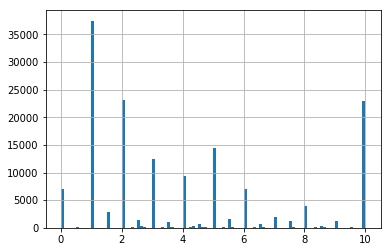

In [64]:
# from another point of view, let's check occurrences of 0-10 in that column.
df_no_dupl.loc[(df_no_dupl['Order_Demand'] >= 0) & (df_no_dupl['Order_Demand'] <= 10)]['Order_Demand'].hist(bins=100)


Number of occurrences for 0 is around 7K. Since it is so low let's assume that orders  with value = 0 are generally not included in the data. This means we need to replace all null values in df_piv by 0.



In [67]:
df_no_dupl_piv.fillna(0)

,"(Product_0001, Whse_A, Category_005)","(Product_0001, Whse_J, Category_005)","(Product_0002, Whse_C, Category_005)","(Product_0002, Whse_S, Category_005)","(Product_0003, Whse_J, Category_005)","(Product_0003, Whse_S, Category_005)","(Product_0004, Whse_J, Category_005)","(Product_0005, Whse_J, Category_005)","(Product_0006, Whse_J, Category_005)","(Product_0007, Whse_J, Category_005)",...,"(Product_2168, Whse_A, Category_024)","(Product_2168, Whse_J, Category_024)","(Product_2168, Whse_S, Category_024)","(Product_2169, Whse_A, Category_024)","(Product_2169, Whse_C, Category_024)","(Product_2169, Whse_J, Category_024)","(Product_2169, Whse_S, Category_024)","(Product_2170, Whse_C, Category_024)","(Product_2171, Whse_J, Category_007)","(Product_2172, Whse_J, Category_005)"
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Export to PBI for EDA

Since we havent replaced any value in the last step, we can export the long format dataframe to csv, for EDA in PBI.
We could have exported a long format version of df_no_dupl_piv, but it would result in 5M rows --> long time to save, slow to work with in PBI, no added value since we only have more zeros.

Thanks to EDA in PBI we see that data is incomplete for 2011 and 2017, and that only 2012 to 2016 is complete. We will export a pickle file with the data in short format, to be used in the forecast model.



In [69]:
# export to csv df with long format
df_no_dupl.to_csv('df_no_dupl.csv', sep=';', decimal=',')

# Filter years with complete data
df_no_dupl_piv = df_no_dupl_piv.loc[df_no_dupl_piv.index.year.isin([2013, 2014, 2015, 2016])]

# export a pickle file with the df in short format
df_no_dupl_piv.to_pickle('df_clean.pkl')
